# Chat GPT Reviews Sentiment Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Functions

In [6]:
def check_for_nulls(df):
  print(f"The Amount of Nulls:{df.isna().sum()}")
  print(f"The Amount of Duplicates:{df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Target Class")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/chatgpt_reviews.csv", nrows=15000)
df

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,26661c9c-2d79-4e19-a7a6-673da6af53f4,Luis Cabrera,magnific!,5,0,1.2024.139,2024-05-29 22:30:43,1.2024.139
1,08d6dd23-e74a-48a5-bab6-7cffa8920a4a,Betty Grayson,it helps me convince my parents to make a mine...,5,0,1.2024.139,2024-05-29 22:29:42,1.2024.139
2,eea7ed5c-b39a-4363-b298-69b6234d0a8a,Abigail Oniyide,"This is the best app I've seen so far, has a l...",5,0,1.2024.131,2024-05-29 22:25:07,1.2024.131
3,b3cf6a61-c88a-4b44-9fec-eb223a1a5109,Sam McGrath,amazing!,5,0,1.2024.131,2024-05-29 22:23:30,1.2024.131
4,15a8fd47-0cf4-447a-a16e-845581e9a448,horii,İnanılmaz.,5,0,1.2024.139,2024-05-29 22:22:29,1.2024.139
...,...,...,...,...,...,...,...,...
14995,fe351276-2e54-4481-b86b-b66e6042ef9f,Thanojreddy Motakatla,very good and fast,5,0,1.2024.115,2024-05-17 03:27:37,1.2024.115
14996,e7c826e7-aade-4902-ae5b-40443286d49a,Prateek Kumar Debta,this app is very good option for children adul...,5,0,1.2024.131,2024-05-17 03:26:50,1.2024.131
14997,4e80301b-e1ea-4a81-9057-30e197895722,Akhasan2002 Love,good,3,0,1.2024.115,2024-05-17 03:26:49,1.2024.115
14998,ebd0836f-d315-40ba-aa07-8bdbb87d64ad,saphaung klein,Great,5,0,1.2024.131,2024-05-17 03:26:13,1.2024.131


# Check For Nulls and Dupes

In [4]:
check_for_nulls(df)

The Amount of Nulls:reviewId                  0
userName                  0
content                   0
score                     0
thumbsUpCount             0
reviewCreatedVersion    787
at                        0
appVersion              787
dtype: int64
The Amount of Duplicates:1201


In [5]:
df.drop_duplicates(inplace=True)

# Check for Class Imbalance

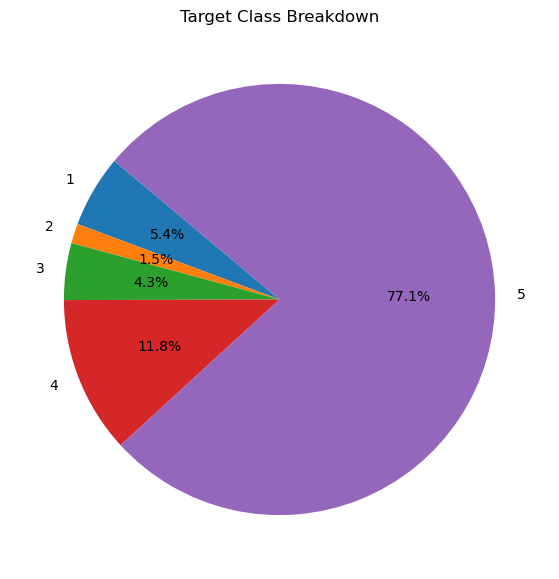

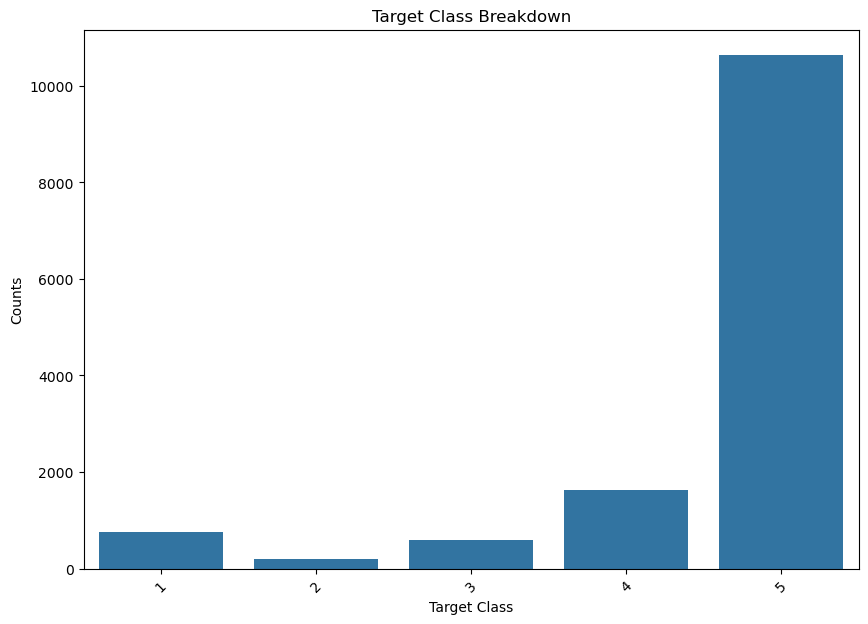

In [8]:
check_class_imbalance(df["score"])

# We have a severe class imbalance in our dataset.

# But people seem to love ChatGPT